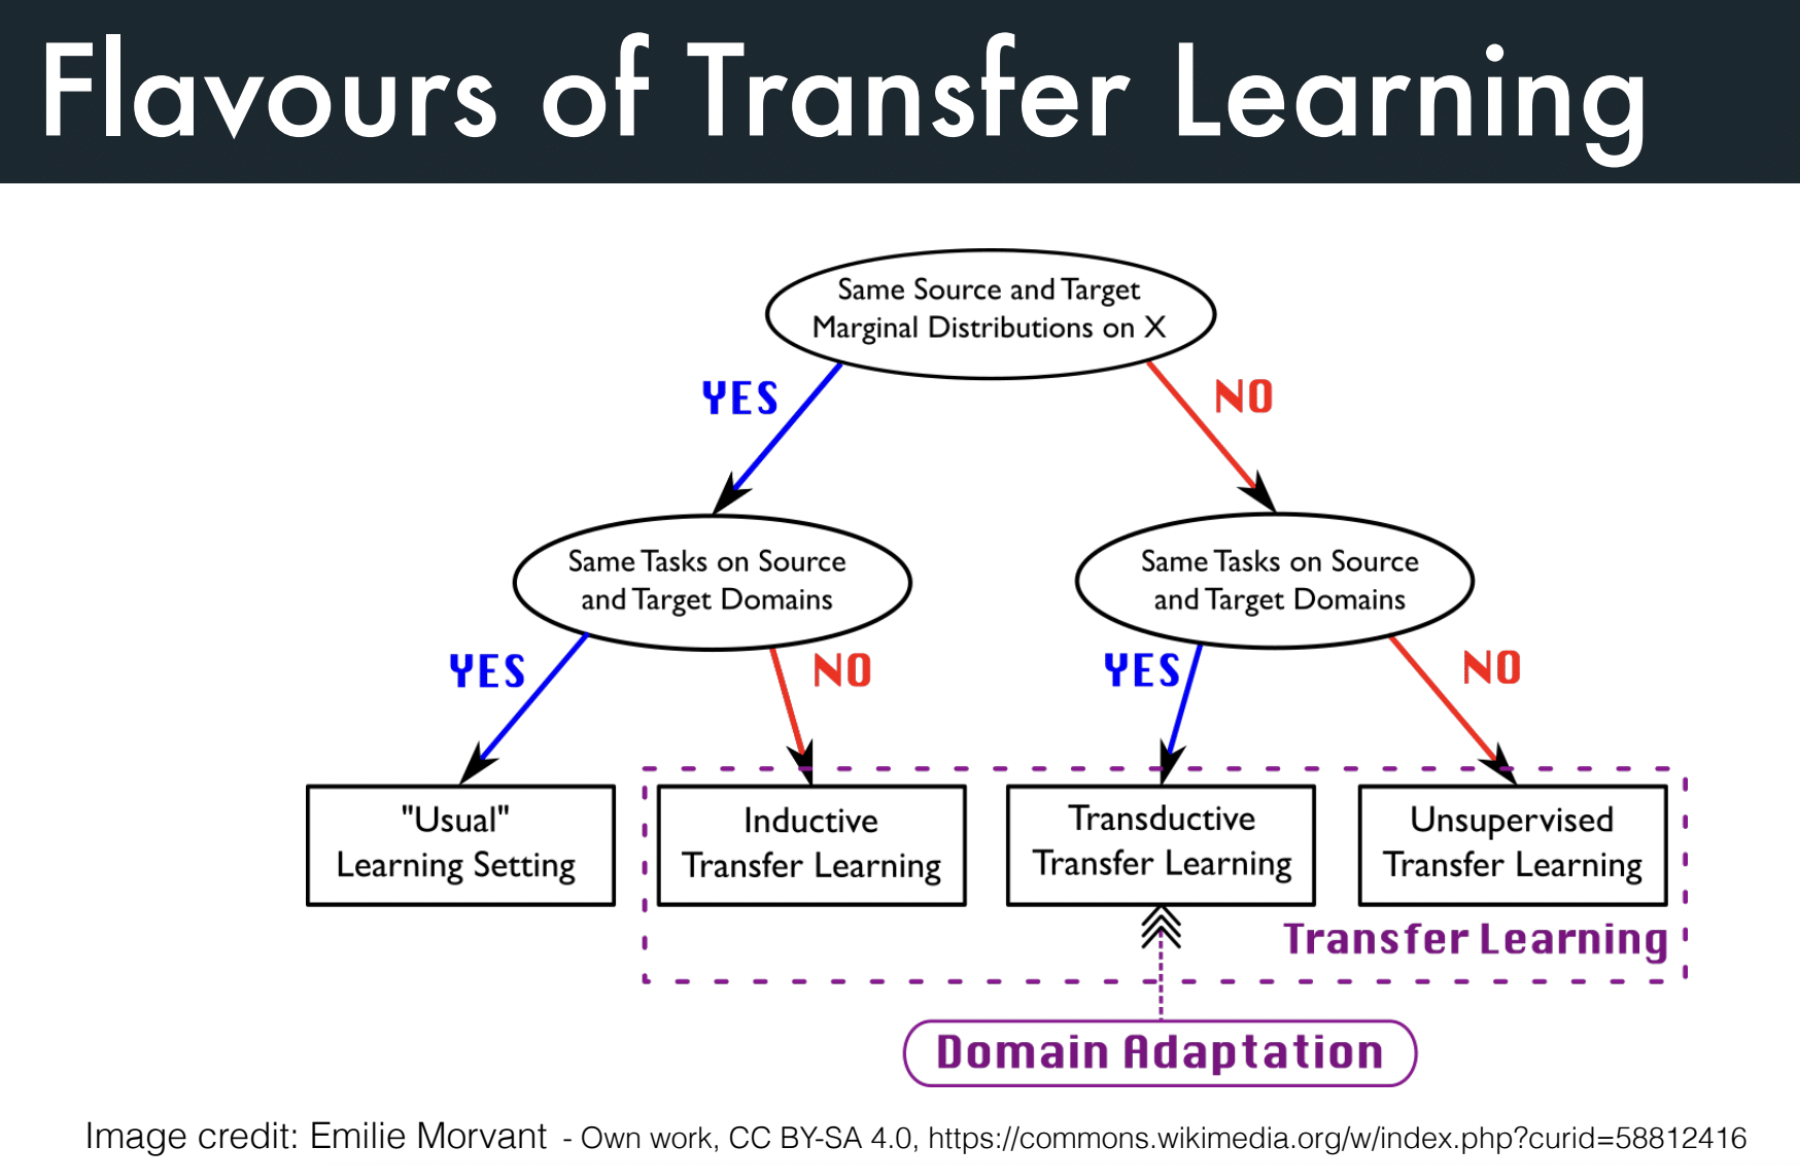

In [ ]:
%%capture
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


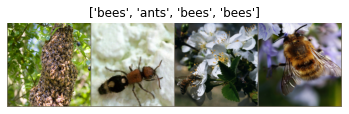

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc,val_loss,val_acc

In [ ]:
def visualize_model_performance(train, val ,title):
  plt.plot([i+1 for i in range(len(train))],train,"-b", marker = 'o', label="train")
  plt.plot([i+1 for i in range(len(val))], val,"-r", marker = '*', label="val")
  plt.xlabel('Epochs')
  plt.ylabel(title)
  plt.title(title)
  plt.show()

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine-tuning Pre-trained ResNet

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5031 Acc: 0.7582
val Loss: 0.2180 Acc: 0.9150

Epoch 1/4
----------
train Loss: 0.5377 Acc: 0.7992
val Loss: 0.1861 Acc: 0.9281

Epoch 2/4
----------
train Loss: 0.5156 Acc: 0.7705
val Loss: 0.2195 Acc: 0.9020

Epoch 3/4
----------
train Loss: 0.4614 Acc: 0.8197
val Loss: 0.2032 Acc: 0.9281

Epoch 4/4
----------
train Loss: 0.3896 Acc: 0.8320
val Loss: 0.2095 Acc: 0.9150

Training complete in 0m 19s
Best val Acc: 0.928105


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


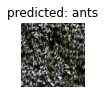

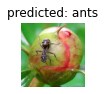

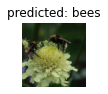

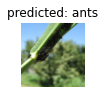

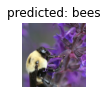

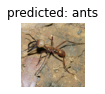

In [ ]:
visualize_model(model_ft)

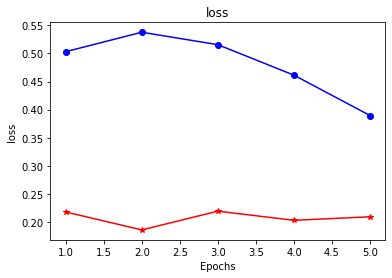

In [ ]:
visualize_model_performance(train_loss, val_loss, 'loss')

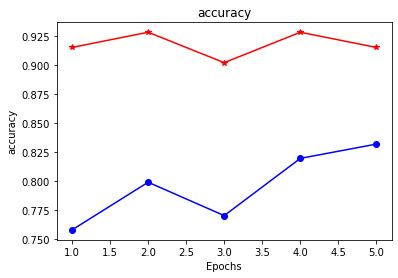

In [ ]:
visualize_model_performance(train_acc,val_acc,'accuracy')

## Pre-trained Model as Feature Extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


In [ ]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_conv, criterion, optimizer_ft,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8397 Acc: 0.4918
val Loss: 0.9265 Acc: 0.4510

Epoch 1/24
----------
train Loss: 0.8219 Acc: 0.5082
val Loss: 0.9197 Acc: 0.4510

Epoch 2/24
----------
train Loss: 0.8347 Acc: 0.5041
val Loss: 0.9188 Acc: 0.4510

Epoch 3/24
----------
train Loss: 0.8327 Acc: 0.5000
val Loss: 0.9032 Acc: 0.4510

Epoch 4/24
----------
train Loss: 0.7980 Acc: 0.5041
val Loss: 0.8615 Acc: 0.4641

Epoch 5/24
----------
train Loss: 0.8107 Acc: 0.5000
val Loss: 0.8740 Acc: 0.4510

Epoch 6/24
----------
train Loss: 0.8274 Acc: 0.4959
val Loss: 0.8949 Acc: 0.4575

Epoch 7/24
----------
train Loss: 0.8340 Acc: 0.5000
val Loss: 0.9218 Acc: 0.4575

Epoch 8/24
----------
train Loss: 0.8459 Acc: 0.5082
val Loss: 0.8912 Acc: 0.4575

Epoch 9/24
----------
train Loss: 0.8072 Acc: 0.5164
val Loss: 0.9294 Acc: 0.4510

Epoch 10/24
----------
train Loss: 0.8226 Acc: 0.5000
val Loss: 0.9083 Acc: 0.4575

Epoch 11/24
----------
train Loss: 0.8052 Acc: 0.5041
val Loss: 0.9234 Acc: 0.4510

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


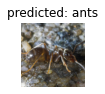

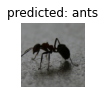

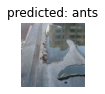

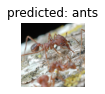

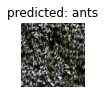

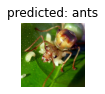

In [ ]:
visualize_model(model_ft)

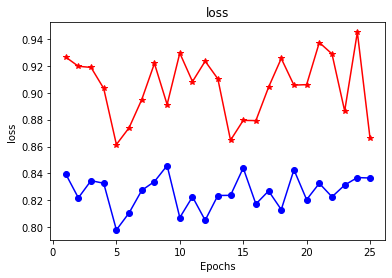

In [ ]:
visualize_model_performance(train_loss, val_loss, 'loss')

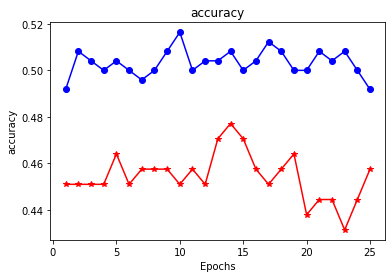

In [ ]:
visualize_model_performance(train_acc,val_acc,'accuracy')

## Random Initialisation (Not-Pretrained)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


In [ ]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_conv, criterion, optimizer_ft,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7430 Acc: 0.5041
val Loss: 0.7955 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.7382 Acc: 0.5041
val Loss: 0.8156 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.7354 Acc: 0.5041
val Loss: 0.7941 Acc: 0.4575

Epoch 3/24
----------
train Loss: 0.7418 Acc: 0.5041
val Loss: 0.8064 Acc: 0.4575

Epoch 4/24
----------
train Loss: 0.7272 Acc: 0.5041
val Loss: 0.8027 Acc: 0.4575

Epoch 5/24
----------
train Loss: 0.7395 Acc: 0.5041
val Loss: 0.8076 Acc: 0.4575

Epoch 6/24
----------
train Loss: 0.7384 Acc: 0.5041
val Loss: 0.7928 Acc: 0.4575

Epoch 7/24
----------
train Loss: 0.7416 Acc: 0.5041
val Loss: 0.7986 Acc: 0.4575

Epoch 8/24
----------
train Loss: 0.7319 Acc: 0.5041
val Loss: 0.7988 Acc: 0.4575

Epoch 9/24
----------
train Loss: 0.7452 Acc: 0.5041
val Loss: 0.8059 Acc: 0.4575

Epoch 10/24
----------
train Loss: 0.7329 Acc: 0.5041
val Loss: 0.8114 Acc: 0.4575

Epoch 11/24
----------
train Loss: 0.7369 Acc: 0.5041
val Loss: 0.8209 Acc: 0.4575

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


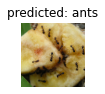

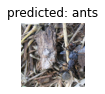

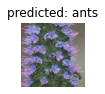

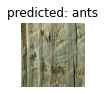

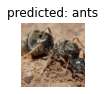

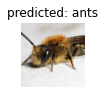

In [ ]:
visualize_model(model_ft)

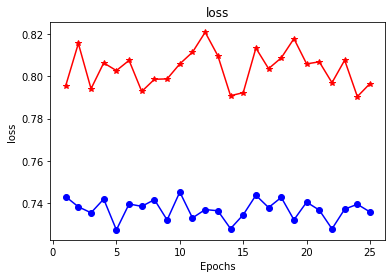

In [ ]:
visualize_model_performance(train_loss, val_loss, 'loss')

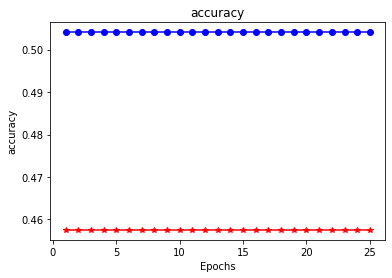

In [ ]:
visualize_model_performance(train_acc,val_acc,'accuracy')